## **Importing required packages:**

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

import pygsm
from pygsm import GlobalSkyModel

import ephem
from astropy.time import Time
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

## **Defining some constants:**

In [4]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548


## **Sky Model part code below:** 

In [42]:
NPIX = hp.nside2npix(16)
T = np.empty(NPIX)

gsm = GlobalSkyModel(freq_unit='GHz')

#**Generating maps for frequencies from 2 to 4 GHz in increment of 100MHz:**

freqs = np.linspace(2,4, 21)
CMB_Int = np.empty(21)
spectrum = gsm.generate(freqs)

#Decreasing the resolution to NSIDE = 16

spec = hp.pixelfunc.ud_grade(spectrum,16)
df = pd.DataFrame(spec)
df = df.transpose()
df.columns = np.arange(2,4.1,0.1)
df = df*1e-20
#Basically 1e-20 factor is to convert MJy/Sr (PyGSM pack has this units) to W/m^2 Hz (SI units)



#Calculation of CMB intensity below

i=0
while i<21:
    CMB_Int[i] = (2*h*math.pow(df.columns[i]*1e9,3.0)/(c*c*math.exp(h*df.columns[i]*1e9/k*TCMB)-1))
    i=i+1
    

CMB = pd.DataFrame(CMB_Int)
CMB.columns = ['CMB Intensity']
CMB = CMB.transpose()
CMB.columns = np.arange(2,4.1,0.1)
CMB = CMB.transpose()


df = df.transpose()
new_df = pd.concat((df, CMB), axis=1)

print(new_df)


for cols in new_df:
    

                0             1             2             3             4  \
2.0  1.953688e-21  1.762710e-21  1.851912e-21  1.907997e-21  2.063368e-21   
2.1  1.668324e-21  1.504584e-21  1.582071e-21  1.630682e-21  1.762666e-21   
2.2  1.437505e-21  1.295934e-21  1.363677e-21  1.406094e-21  1.519318e-21   
2.3  1.249786e-21  1.126370e-21  1.185943e-21  1.223188e-21  1.321296e-21   
2.4  1.095265e-21  9.868828e-22  1.039554e-21  1.072446e-21  1.158213e-21   
2.5  9.649981e-22  8.693141e-22  9.161179e-22  9.453138e-22  1.020701e-21   
2.6  8.543407e-22  7.694615e-22  8.112450e-22  8.372812e-22  9.038698e-22   
2.7  7.597572e-22  6.841282e-22  7.215904e-22  7.449092e-22  8.039922e-22   
2.8  6.784478e-22  6.107834e-22  6.445050e-22  6.654739e-22  7.181172e-22   
2.9  6.081765e-22  5.474063e-22  5.778731e-22  5.967991e-22  6.438876e-22   
3.0  5.471432e-22  4.923701e-22  5.199912e-22  5.371327e-22  5.794055e-22   
3.1  4.938877e-22  4.443553e-22  4.694773e-22  4.850529e-22  5.231314e-22   

## **LST calculation and Coordinate transform:**

In [5]:
#Sidereal time calculation

Obs = ephem.Observer()
t = Time('2022-05-09 16:15:00.0000', scale='utc',location=('10', '0'))
lst = t.sidereal_time('apparent')
print(lst)


#Checking the number of pixels

NPIX = hp.nside2npix(16)
print(NPIX)

i=1
alt = np.empty(NPIX)
az = np.empty(NPIX)

#For every pixel, get the horizontal coordinate. 

while i<NPIX:
    coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)
    gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
    
    equi = gc.transform_to(AltAz(obstime = '2022-06-08T11:10:10.10', location = EarthLocation(lat = 12.9716*u.deg, lon=77.5946*u.deg, height=900*u.m)))
    
    #Getting the magnitude of azimuthal value alone in deg
    az[i-1]= equi.az .value 
    
    #Getting the magnitude of altitude value alone in deg
    alt[i-1] = equi.alt .value 
    
    i=i+1

print(az) #List of az for each pixel as an array
print(alt) #List of alt for each pixel as an array


8h04m49.48176101s
3072
[6.16171970e+001 6.58797488e+001 6.92308200e+001 ... 2.45044232e+002
 2.41621672e+002 6.91769637e-310]
[ 4.05126470e+001  4.31621157e+001  3.98745462e+001 ... -3.73540173e+001
 -4.05179033e+001  6.91769635e-310]


## **Recombination data: Intensity vs frequency**

/tmp/ipykernel_4825/2477689297.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/Downloads/total_spec_new.txt',sep= "    " ,header = None)


        Frequency     Intensity
0        0.009984  1.255914e-32
1        0.010003  1.258055e-32
2        0.010022  1.260196e-32
3        0.010041  1.262337e-32
4        0.010061  1.264478e-32
...           ...           ...
6835  4966.790300  2.870275e-33
6836  4976.331500  2.601257e-33
6837  4985.890900  2.353869e-33
6838  4995.468700  2.126862e-33
6839  5005.064900  1.918862e-33

[6840 rows x 2 columns]


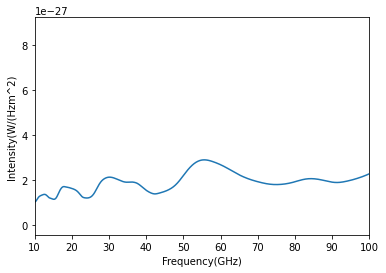

In [2]:
df = pd.read_csv(r'/home/dhashin/Downloads/total_spec_new.txt',sep= "    " ,header = None)


df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]
print(df)

#ploting graph of intensity vs frequency

plt.plot(df["Frequency"],df["Intensity"])
plt.xlim(10,100)
plt.xlabel('Frequency(GHz)')
plt.ylabel('Intensity(W/(Hzm^2)')

plt.show()

x = df["Frequency"]
y= df["Intensity"]

ius = InterpolatedUnivariateSpline(x, y)

## **Function to generate map of visible sky given the location and time:**

In [17]:
NPIX = hp.nside2npix(16)
print(NPIX)

gsm = GlobalSkyModel(freq_unit='GHz')


def Visible_Sky(frequency, latitude, longitude, altitude, T):           #Here frequency is taken in GHz, lat and lon in degrees and T is the format 'YYYY-MM-DD HH:MM:SS.SS'
    spectrum = gsm.generate(frequency)
    spectrum = hp.pixelfunc.ud_grade(spectrum, 16)                      #Reducing the resolution to NSIDE=16

    i=1

    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = T, location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
        
        #If alt<0 in horizontal coordinates, that is not visible for the observer. So, suxh pixels are given minimum value (grey in map)
        if (equi.alt<0):
            spectrum[i-1] = -1.6375e+30
    
        i = i+1  
    print(spectrum)
    
spectrum_value = Visible_Sky(2,10,10,200,'2022-05-15 12:00:00')
print(spectrum_value)


3072
[-1.63750000e+30 -1.63750000e+30 -1.63750000e+30 ...  2.09467862e-01
  2.01622466e-01  1.92877833e-01]
None


Remember: CMB intensity addition

In [ ]:
#Changing intensity to temperature scale

# for cols in df:
#     df[cols] = df[cols].apply(lambda x:(h* df.columns*1e9)/(k) * (0.5 + (x*1.25664e-20*c*c/(2*h*df.columns*df.columns*df.columns*1e27))))

